# Reconstructing Temperature Response Functions
Look at how selecting certain elements/ions impacts predictions of the intensity as compared to the actual temperature response functions.

In [19]:
import urllib
import io

import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.interpolate
#import seaborn
import astropy.units as u
import plasmapy
import fiasco
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import Element,Ion,EmissionModel,list_elements

%matplotlib inline

In [2]:
temperature = 10.**(np.arange(5,8.1,0.1))*u.K
density = np.logspace(15-np.log10(temperature.value.max()),15-np.log10(temperature.value.min()),5)/(u.cm**3)

In [3]:
accepted_elements = [
    'iron',
    'calcium',
    'magnesium',
    'oxygen',
    'silicon',
    'sulfur',
    'nickel'
]
ions = [Element(el,temperature=temperature,ion_kwargs={'abundance_filename':'sun_coronal_1992_feldman'})
        for el in accepted_elements]

In [4]:
em_model = EmissionModel(density,*ions)

In [5]:
em_model.calculate_emissivity('/Users/willbarnes/Desktop/emiss_table.h5',notebook=True)
#em_model.emissivity_savefile = '/Users/willbarnes/Desktop/emiss_table.h5'

FloatProgress(value=0.0)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev710-py3.6.egg/synthesizAR/atomic/chianti.py:111: RuntimeWarning: invalid value encountered in greater
  ex_rate = u.Quantity(np.where(ex_rate > 0., ex_rate, 0.), u.cm**3/u.s).T


In [6]:
aia = InstrumentSDOAIA([0,1]*u.s)

In [7]:
calc_temp_response = {}
for channel in aia.channels:
    counts = np.zeros(em_model.temperature.shape+em_model.density.shape)
    components = {}
    for ion in em_model:
        wvl,emiss = em_model.get_emissivity(ion)
        if wvl is None or emiss is None:
            continue
        response = scipy.interpolate.splev(wvl.value,channel['wavelength_response_spline'])
        response = np.where(response < 0., 0., response)
        tmp = np.dot(emiss.value,response)
        ab = ion.abundance.value
        tmp *= ab*ion.ioneq.value[:,np.newaxis]/em_model.density.value/4./np.pi
        counts += tmp
        if ion.element_name in components:
            components[ion.element_name] += tmp
        else:
            components[ion.element_name] = tmp
    calc_temp_response[channel['name']] = counts
    calc_temp_response[f'{channel["name"]}_components'] = components

In [8]:
const_p_indices = np.array([(i,np.argmin(np.fabs(em_model.density.value-d.value))) 
                            for i,d in enumerate(1e15/em_model.temperature)])

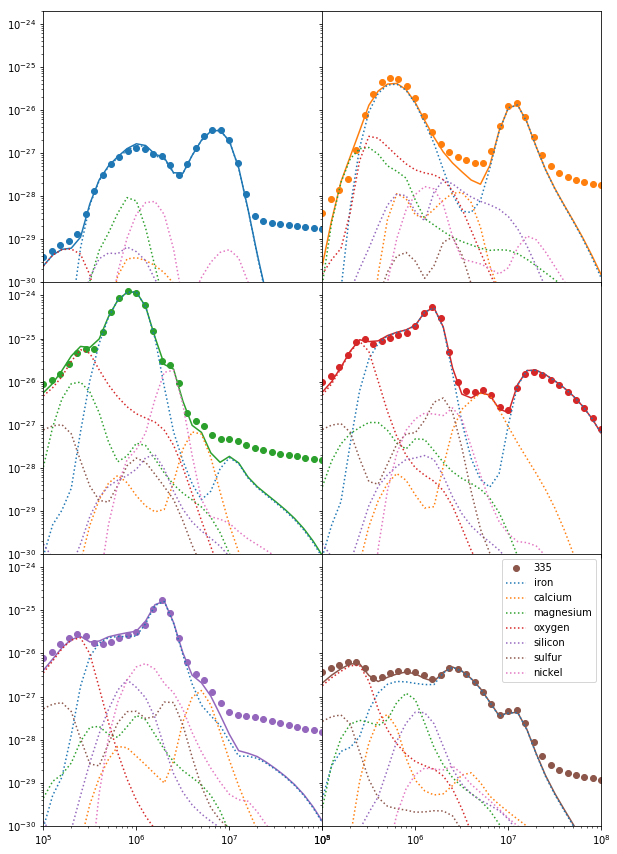

In [10]:
fig,axes = plt.subplots(3,2,figsize=(10,15),sharex=True,sharey=True)
data_temperature = np.logspace(5,8,100)
for i,(ax,channel) in enumerate(zip(axes.flatten(),aia.channels)):
    real_response = scipy.interpolate.splev(data_temperature,channel['temperature_response_spline'])
    ax.plot(data_temperature,real_response,
            'o',markevery=3,color=f'C{i%10}',label=channel['name'])
    ax.plot(em_model.temperature,calc_temp_response[channel['name']][const_p_indices[:,0],const_p_indices[:,1]],
             color=f'C{i%10}',ls='-')
    for j,element in enumerate(calc_temp_response[f'{channel["name"]}_components']):
        ax.plot(em_model.temperature,
                calc_temp_response[f'{channel["name"]}_components'][element][const_p_indices[:,0],const_p_indices[:,1]],
                color=f'C{j%10}',ls=':',label=element)
    #ax.axvline(x=1e6,ls='--',color='k')
    #ax.axvline(x=1e7,ls='--',color='k')
    if i==5:
        ax.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30,2e-24])
plt.xlim([1e5,1e8])
#plt.legend()
plt.subplots_adjust(wspace=0.,hspace=0.)

In [11]:
test_ion = Ion('H 1',[1e6,1e7]*u.K)

In [12]:
density = np.logspace(8,11,10)/(u.cm**3)

In [15]:
wvl,emiss = test_ion.emissivity(density,include_energy=True)

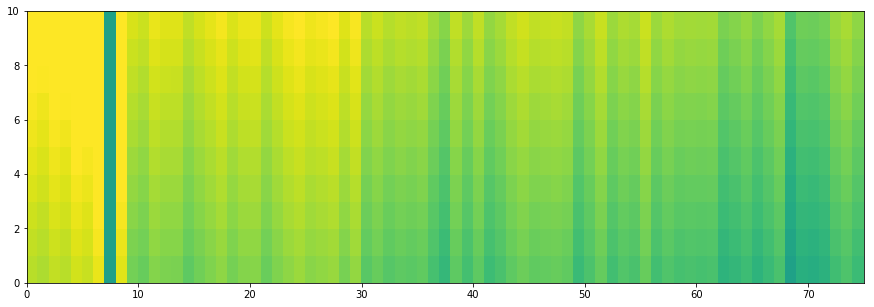

In [23]:
plt.figure(figsize=(15,5))
plt.pcolormesh(emiss[1,:,np.argsort(wvl.value)].T,
               norm=matplotlib.colors.SymLogNorm(1e-100,vmin=1e-30,vmax=1e-10))